In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import sys

In [4]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.2.1 
xwmb version 0.2.1


### Request HPC Resources

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='50GB',
    walltime='02:00:00',
    queue='scavenger',
    interface='ib0', 
log_directory ="/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/slurmscratch")
print(cluster.job_script())
cluster.scale(jobs=2)

client = Client(cluster)
client

2024-11-11 22:30:22,906 - distributed.diskutils - ERROR - Failed to remove '/tmp/dask-scratch-space/scheduler-80gd_obz' (failed in <built-in function open>): [Errno 13] Permission denied: '/tmp/dask-scratch-space/scheduler-80gd_obz'


#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/slurmscratch/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/slurmscratch/dask-worker-%J.out
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=47G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.102:36549 --name dummy-name --nthreads 36 --memory-limit 46.57GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.102:36549,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load in data

In [38]:
def approximate_z(ds, dim = "zl"):
    tmp = ds.thkcello.cumsum(dim = dim)
    #average between 0 and cell bottom
    tmp1 = tmp.isel({dim: 0}) / 2 
    #get top of cell
    tmp2 = tmp.isel({dim : slice(0, -1)}) 
    #get bottom of cell
    tmp3 = tmp.isel({dim : slice(1, None)}) 
    #make sure cell interfaces are on same coordinate
    tmp2.coords[dim] = tmp3.coords[dim]
    #take average
    tmp4 = (tmp2 + tmp3) / 2

    ds["z"] = xr.concat([1. * tmp1, 1. * tmp4], dim = dim)    
    ds["z_bottom"] = 1. * tmp

    return ds

def vertical_average(ds, varname = "cfc11"):
    tmp = (ds["thkcello"] * ds[varname]).sum("sigma2_l")
    
    return tmp / ds["thkcello"].sum("sigma2_l")

In [84]:
# fname = "../../data/model/CM4Xp125_budgets_sigma2_2020-2024.zarr"
fname = "../../data/model/CM4Xp25_ssp585_tracers_sigma2_2020-2024.zarr"

ds = xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
ds = ds.fillna(0.) #remove all NaNs
ds['mask'] = (
    (ds['geolat'] <= -40) * \
    (ds['geolat'] >= -60)
)
ds = approximate_z(ds, dim = "sigma2_l")

In [85]:
# fname = "../../data/model/CM4Xp125_budgets_sigma2_2020-2024.zarr"
fname = "../../data/model/CM4Xp125_piControl_tracers_sigma2_0271-0275.zarr"

ds_ctrl = xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
ds_ctrl = ds_ctrl.fillna(0.) #remove all NaNs
ds_ctrl['mask'] = (
    (ds_ctrl['geolat'] <= -40) * \
    (ds_ctrl['geolat'] >= -60)
)
ds_ctrl = approximate_z(ds_ctrl, dim = "sigma2_l")

Text(0.5, 1.0, 'Southern Ocean mask')

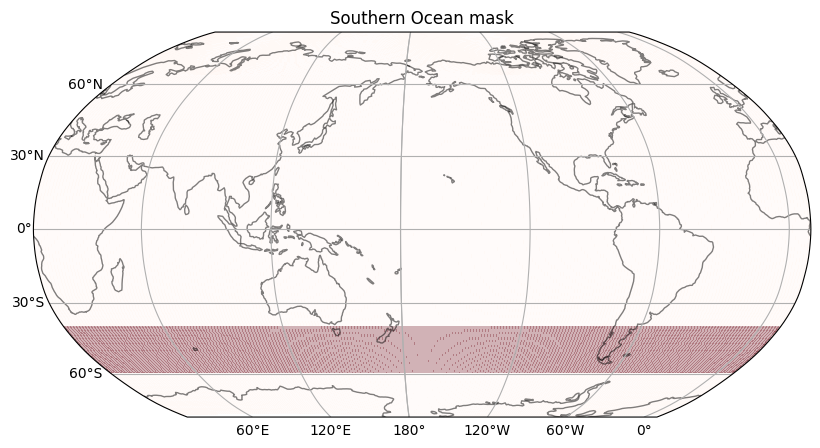

In [86]:
fig, ax = plt.subplots(figsize=[20,5], subplot_kw={'projection':ccrs.Robinson(190)})
ax.pcolormesh(ds['geolon'], ds['geolat'] , ds['mask'], 
              transform = ccrs.PlateCarree(), cmap = "Reds", alpha = 0.3)
ax.coastlines(alpha = 0.5)
gl = ax.gridlines(draw_labels = True)
gl.top_labels = False
gl.right_labels = False
ax.set_title("Southern Ocean mask")

### Define region with ``regionate``

In [87]:
regions = MaskRegions(ds.mask, grid).region_dict
antarctic = regions[0] #there are more in this list if there are multiple contours 
region = GriddedRegion("antarctic", antarctic.lons, antarctic.lats, grid, ij=(antarctic.i, antarctic.j))

In [88]:
ds_sfc = ds.where((ds["z"] < 10) * ds["mask"])
tmp = (ds_sfc["cfc11"] * ds_sfc["thkcello"]).sum(["sigma2_l", "xh", "yh"])
sfc_cfc = tmp / ds_sfc["thkcello"].sum(["sigma2_l", "xh", "yh"])
sfc_cfc = sfc_cfc.compute()

In [89]:
ds_ctrl_sfc = ds_ctrl.where((ds_ctrl["z"] < 10) * ds_ctrl["mask"])
tmp = (ds_ctrl_sfc["cfc11"] * ds_ctrl_sfc["thkcello"]).sum(["sigma2_l", "xh", "yh"])
sfc_ctrl_cfc = tmp / ds_ctrl_sfc["thkcello"].sum(["sigma2_l", "xh", "yh"])
sfc_ctrl_cfc = sfc_ctrl_cfc.compute()

In [90]:
sfc_ctrl_cfc.coords["time"] = sfc_cfc.time.values

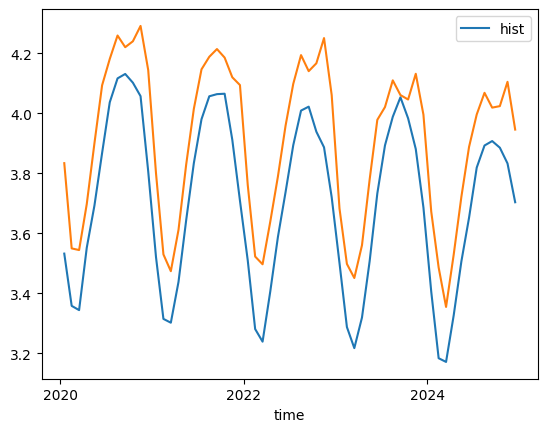

In [98]:
(1e12/1035 * sfc_cfc).compute().plot(label = "hist")
( 1e12/1035 * sfc_ctrl_cfc).compute().plot()
plt.legend()

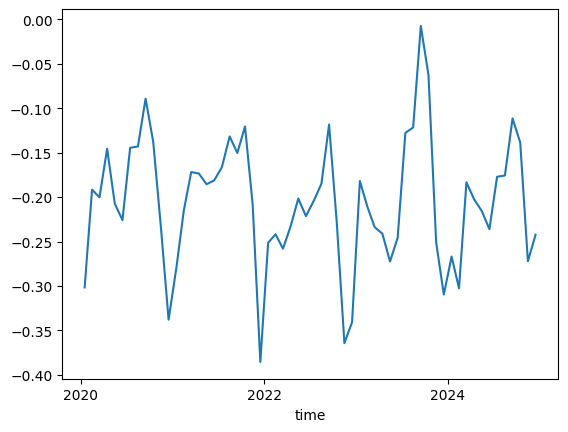

In [96]:
(1e12/1035 * (sfc_cfc - sfc_ctrl_cfc)).plot(label = "diff")
